## Transfer Learning on Flowers Dataset

<a href="https://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.pdf">Official Paper</a>&emsp;<a href="https://www.robots.ox.ac.uk/~vgg/data/flowers/102/">Official Page</a>&emsp;<a href="https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz">Download Dataset</a>&emsp;<a href="https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1">Download Labels</a>

---

#### Project Description
Although the idea of Deep Learning was born almost 80 years ago, we are just given the opportunity to bring any sophisticated ideas to life. That is why we will be looking at the extensively researched case of classfying 102 categories of flowers. Even though the task does not sound hard, the challenges arise in the similarity in both color and shape, which can be seen here:
<img src='images/shape_color.png'>

To elaborate on the topic of similarities, there are nine types of lilies (Giant White Arum, Fire, Water, Toad, Blackberry, Sword, Tiger, Peruvian, Canna) and two types of irises (Bearded, Yellow). Additional difficulties can be found with the non-conventional distribution of training (12.45%), validation (12.45%), and testing (75.1%) sets. 

The project will be worked around ResNet34 (34 convolutional layers) model which is a residual network that was trained on ImageNet's images. It is considerately smaller than most of the other models with only 20 million parameters. Thus, the training part will not take long even on CPU mode (from my findings, running 15 epochs takes around 40 minutes). 
![Pre-trained models](images/models.png)



### Table of Content:
* [Read the data](#read-data)
* [Success!](#success)
* [Create the loaders and Visualize](#create-loaders)
* [Time to train our model!](#train)
* [Compare results](#compare)
* [Additional challenge](#challenge)
* [Last prediction](#prediction)


In [1]:
# import essential packages
import os
import json 
import random
from PIL import Image

import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import torch
from torch import nn
from torch import optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# additional helper function to do behind the scene
import helper
import visualize
import train_test

# disable warning signs 
import warnings
warnings.filterwarnings('ignore')

# set an aesthetically pleasing theme
sns.set()

### Read the Data <a class="anchor" id="read-data">
The data provided by the fellowship-ai was presented in a huge folder with 8189 images along with text files containing training, test, and validation paths and their respective targets.  

![Folder Structure](images/structure.png)
    
Instead of finding the formatted folders online, I decided to take some time to deal with formatting manually. The formatting is essential for further usage of ImageFolder and DataLoader to read, transform, and create batches of data. To be able to use these functions, we need to have the following folder structure:
```
root/class_1/xxx.jpg
root/class_1/xxy.jpg
root/class_1/xxz.jpg

root/class_2/123.jpg
root/class_2/nsdf3.jpg
root/class_2/asd932_.jpg
```

#### Steps:
* Read the content of three sets (train, test, and validation)
* Create a dataframe to store all paths and targets <b>if</b> 'jpg' folder exists (to transfer the images to correct folders)
* Increase the index of all DataFrames and Series by 1 (indexing starts from 1 in target column)
* Create two target dictionaries to store <i>number:column</i> and <i>column:number</i> for better visualization 
* Create folders and transfer images from 'jpg' to their respective folders
    
---
#### Explanations 
<b>Why create a DataFrame to store all paths and targets?</b> Since I'm manually creating the folders, there was the need to iterate over the whole file and transfer the images accordingly.<br>
<b>Why increase by 1?</b> While creating the dataframes, their indices automatically start from 0. During the visualization step, I saw that the labels were interpreted incorrectly. At that time I realized that indexing of targets in the MATLAB file start from 1. 


In [2]:
# read the paths and targets, store them in dataframes 
train_df = pd.read_csv('paths/train.txt', sep=' ', names=['path', 'idx'])
test_df = pd.read_csv('paths/test.txt', sep=' ', names=['path', 'idx'])
valid_df = pd.read_csv('paths/valid.txt', sep=' ', names=['path', 'idx'])

# check the number of images in each dataframe
for df, name in [(train_df, 'train'), (test_df, 'test'), (valid_df, 'validation')]:
    print(f'{name} contains {df.shape[0]} images')

train contains 1020 images
test contains 6149 images
validation contains 1020 images


In [3]:
# if the 'jpg' file exists, create a dataframe to store all paths and targets
if os.path.exists('jpg'):
    # MATLAB returns a tuple, we need the first value which stores the array of target indices
    labels = scipy.io.loadmat('paths/imagelabels.mat')['labels'][0]
    # get all filenames from 'jpg' directory
    dataset = os.listdir('jpg')
    # store both results in a dataframe
    df = pd.DataFrame({'path': dataset, 'target': labels})
    # create a dataframe to not break the code after folder creation 
    df.to_csv('paths/dataframe.csv', index=False)

# otherwise read the existing dataframe
else:
    df = pd.read_csv('paths/dataframe.csv')

# read the class names and increase index by 1 
classes = pd.read_csv('paths/class_names.txt', names=['target'])
classes.index += 1

# remove the unnecessary punctuation marks 
label_dict, label_inverse = labels_dict = helper.prettify(classes)

# check for correctness 
next(iter(label_dict.items()))

(1, 'Pink Primrose')

In [4]:
#### Main part to create and transfer images ####

# helper.create_folders(df)   ## uncomment if you need to create the folders

# transfer the images from "jpg" folder to their appropriate files 
# helper.transfer([train_df, test_df, valid_df], df)   ## uncomment to transfer images

### Success! <a class="anchor" id="success">
Now the folders are in the format that I initially wanted to work with. They have the following format: <br>
![](images/right_folder.png)

However, there biggest issue is that PyCharm automatically sorts folders alphabetically. When I created the folders, I was using numbers to initialize them, thus the IDE did its intelligent thing to prettify the results by sorting them as <b>numbers</b>. When the DataLoader checks the structure, it reads them as <b>strings</b>. I had to manually create a holder which stores the DataLoader structure. It was done by writing this complex structure:<br>
<code>sorted([str(x) for x in df['target'].unique().astype('object').tolist()])</code><br>

<b>Let's break it down</b>:
1. Get the unique instances of target column (1-102);
2. Change the data type, so it is not a number anymore;
3. Turn pandas Series to list;
4. Convert each instances to string;
5. Sort alphabetically

As a result, we get the following <b>correct</b> structure which will be stored in "actual_order" variable:<br>
<code> 1, 10, 100, 101, 102, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 
    29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 
    52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 
    76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99</code>


#### Trials 
At the very beginning, I wanted to create a string representation of folders with their actual names. However, doing so increased the complexity of finding the label's patterns in the visualization step. It was labeling sunflowers as roses, wallflowers as orange dahlia, and so on. I was sure there was a bug that I failed to look at. And after around 18-25 hours, thanks to <a href='https://github.com/pytorch/vision/issues/714'>this reply</a>, everything made sense! Here's the initial folder screenshot:
![](images/wrong_folders.png)

### Create the loaders and Visualize <a class="anchor" id="create-loaders"/>
Time to build the loaders and visualize the transformations applied to training set. To not clutter this page, all the instantiations happen <a href=''>here</a>. The following transformation were applied: <br>
<b>train</b>:
* Resize (226 pixels) & CenterCrop (224 pixels): ResNet34 requires the input images to have 224x224x3 dimensions (and just in general, all the pre-trained models require such input)
* RandomRotation by 10 degrees in both clockwise and anti-clockwise directions
* ToTensor: All the loaders have to be tensors
* Normalization: The standard form of mean (0.485, 0.486, 0.406) and standard deviation (0.229, 0.224, 0.225)

<b>test & validation</b>:<br>
All the transformations except for RandomRotation.

**Additional Remarks**: 
It's crucial to keep in mind the order of transformations. We cannot apply normalization before ToTensor, otherwise it will not work. Also, validation set cannot use the same transformation as training ones (because they're used for testing purposes as well). 
    
---
In order to visualize a batch, we need to un-normalize the data. The easiest way that I found to work is the following two-step transformation composition:
```
transforms.Compose([transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]), ])
```

In [5]:
# set the batch size
n_batches = 20

# create loaders with specified batch size
train_loader, test_loader, valid_loader = helper.create_loaders(n_batches)

# create an iterable from the train loader to easier visualize random batches
batch = iter(train_loader)

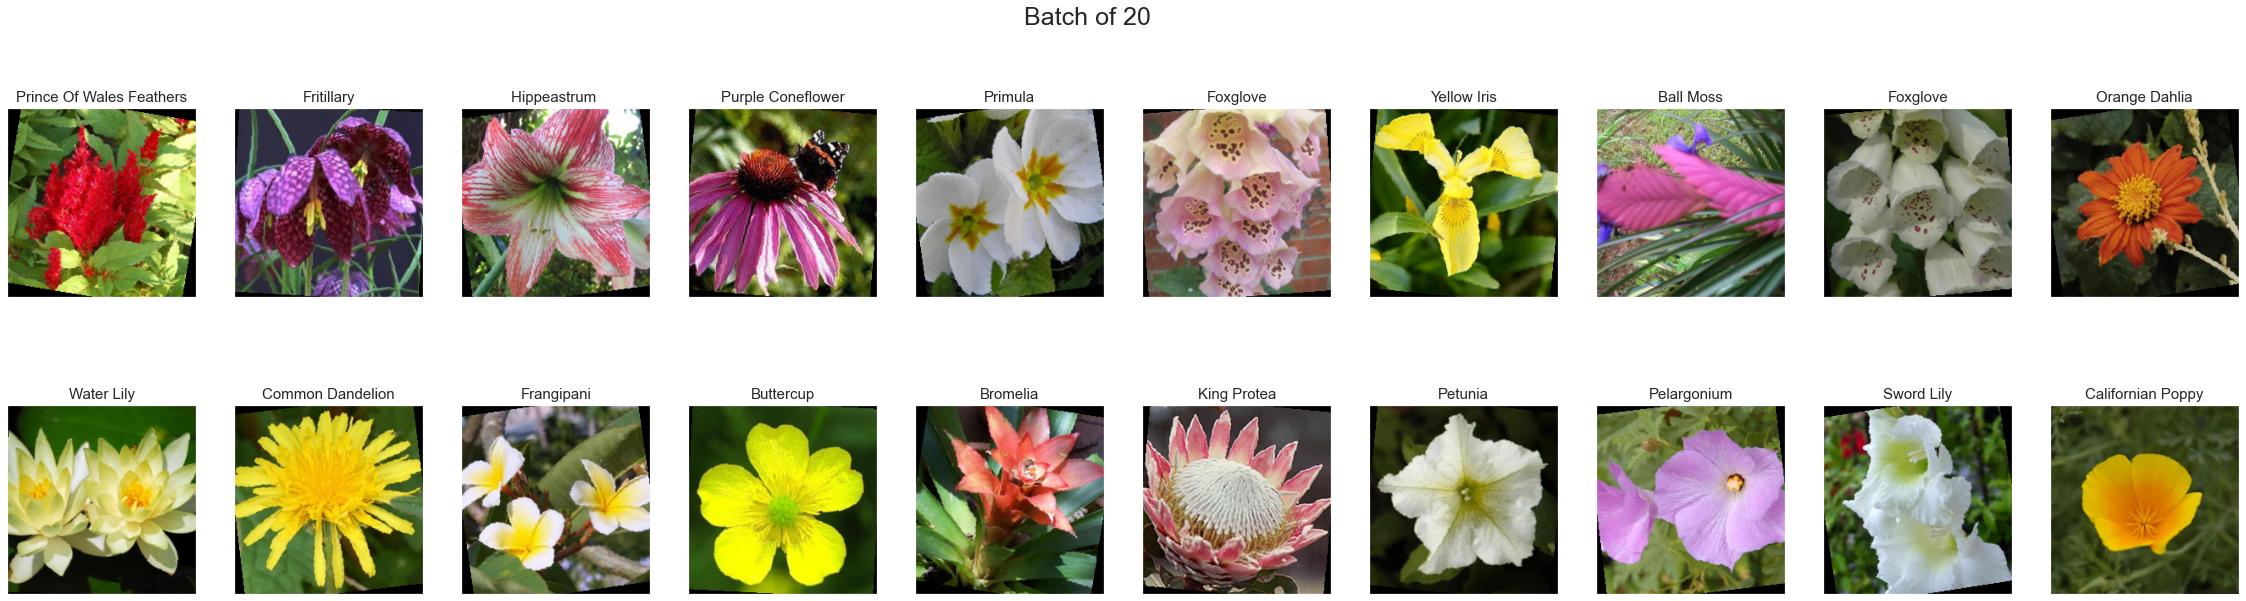

In [6]:
# get the correct labels (see "Success" section to learn about it)
actual_order = sorted([str(x) for x in df['target'].unique().astype('object').tolist()])
visualize.batch(batch, label_dict, n_batches, actual_order)

#### Visualize the distribution of flowers
Since we already know that there are 1020 instances in the training set, I want to check the number of images in each class. The importance of doing so is to see if there's a class imbalance that needs to be taken care of. As we see, there's an equal distribution of the images, which is incredible! We can now proceed to the next section.

In [9]:
visualize.hist(targets=label_dict)

There are 10 images in each folder


### Time to train our model! <a class="anchor" id="train"/>
This part is just to see how well the model does to make changes accordingly. There are three just-to-see-the-results initializations that I will be looking at: SGD (Stochastic Gradient Descent, 2 instances with different learning rates), Adagrad, and Adam optimizers along with an exponential learning rate scheduler. While choosing which optimizer to go with, I saw multiple opinions on them. It was quite biased, so I decided to give them all a try. Later on, we will compare the results :) 

However, let's still elaborate on the choice of the models.<br>
1. SGD + momentum + Nesterov<br>
Being inspired by <cite data-cite="sutskever2013importance">"On the importance of initialization and momentum in deep learning"</cite> [1], I'm using the SGD model along with momentum and Nesterov (which is also knows as Nesterov's Accelerated Gradient(NAG)). Momentum is a technique that helps gradient not to get stuck in a local minima by bouncing off. However, it still can overshoot sometimes. That's why we need to enable Nesterov to maximize the probability of finding the global minima. 
**Additional remark**: I'm still knew to the whole Deep Learning concept, that's why there are two initialization with different learning rates that were manually selected.

2. Adagrad <br>
Adagrad is a good optimizer that can be beneficial for not finetuning learning rates since it adapts them accordingly. It does so by making minimal changes on frequently occuring features, and large changes on the otherwise. One of the biggest disadvantages of this optimizer is the "the accumulation of the squared gradients in the denominator. Since every added term is positive, the accumulated sum keeps growing during training, causing the learning rate to shrink and becoming infinitesimally small" [2].

3. Adam <br>
Adam is also an adaptive learning rate optimization. As SGD, it has a possibility to run with momentum, which I used in the training. Additional unarguable advantage of it is the ability to work with noisy and/or sparce gradients. 

Let's see which model will be able to predict the best!

In [7]:
# set the best model's paths
sgd_path1 = f'models/sgd_momentum_lr1e-2.pt'
sgd_path2 = f'models/sgd_momentum_lr1e-3.pt'
adagrad_path = f'models/adagrad.pt'
adam_path = f'models/adam.pt'

# set the json paths
sgd_json1 = 'models/sgd_momentum1.json'
sgd_json2 = 'models/sgd_momentum2.json'
adagrad_json = 'models/adagrad.json'
adam_json = 'models/adam.json'

# store the results of different models
results = []

# set epochs and batches
epochs = 12
batchces = 10

# transfer to CUDA if applicable
use_cuda = torch.cuda.is_available()

In [8]:
def get_model():
    model = models.resnet34(pretrained=True)
    # change the out features
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 102)

    if use_cuda:
        model = model.cuda()
    return model


def train_valid_test(learning_decay, optim_name, epochs, batches, save_path, json_path, idx, lr):
    # get the model
    model =  get_model()
    
    # train, validate, and test the model
    train_loss, valid_loss, test_loss, model, confused_with, test_dict = train_test.set_params(
        epochs, model, label_dict, actual_order, use_cuda, save_path=save_path,
        learning_decay=learning_decay, optim_name=optim_name, n_batch=batches, lr=lr)
    
    # store the results
    results.append({'train_loss': train_loss, 'valid_loss': valid_loss, 'test_loss': test_loss,
                   'confused_with': confused_with, 'test_dict': test_dict, 'path': save_path,
                    'optim': optim_name, 'batch_size': batches})
    
    with open(json_path, 'w') as file:
        json.dump(results[idx], file)


========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: SGD
    Batch size: 10
    Path: models/sgd_momentum_lr1e-3.pt
    Epochs: 12
    Learning rate: 0.01
    
Validation loss decreased (inf --> 3.920968).  Saving model ...
Validation loss decreased (3.920968 --> 2.919233).  Saving model ...
Validation loss decreased (2.919233 --> 1.822778).  Saving model ...
Validation loss decreased (1.822778 --> 1.559031).  Saving model ...
Epoch: 5 	Training Loss: 0.469737 	Validation Loss: 1.240159
Validation loss decreased (1.559031 --> 1.240159).  Saving model ...
Validation loss decreased (1.240159 --> 0.862983).  Saving model ...
Validation loss decreased (0.862983 --> 0.769709).  Saving model ...
Validation loss decreased (0.769709 --> 0.760111).  Saving model ...
Epoch: 10 	Training Loss: 0.024236 	Validation Loss: 0.780542
Validation loss decreased (0.760111 --> 0.705338).  Saving model ...


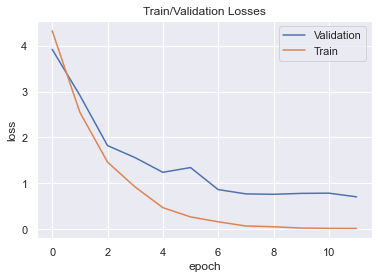

Test Loss: 0.753389


Test Accuracy: 81% (5021/6149)
========== Ending Training ==========
    Train loss: 0.01660088535430202
    Valid loss: 0.7053381272171643
    Test  loss: 0.7533888421360239
    


In [17]:
##############################
# Train using SGD optimizer #
#############################
# Momentum + Nesterov + 1e-2 LR 

train_valid_test(True, 'SGD', epochs, batches, sgd_path1, sgd_json1, 0, 0.01)

========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: SGD
    Batch size: 10
    Path: models/sgd_momentum_lr1e-3.pt
    Epochs: 12
    Learning rate: 0.001
    
Validation loss decreased (inf --> 3.160527).  Saving model ...
Validation loss decreased (3.160527 --> 1.996885).  Saving model ...
Validation loss decreased (1.996885 --> 1.355551).  Saving model ...
Validation loss decreased (1.355551 --> 1.033857).  Saving model ...
Epoch: 5 	Training Loss: 0.656409 	Validation Loss: 0.838274
Validation loss decreased (1.033857 --> 0.838274).  Saving model ...
Validation loss decreased (0.838274 --> 0.748592).  Saving model ...
Validation loss decreased (0.748592 --> 0.670311).  Saving model ...
Validation loss decreased (0.670311 --> 0.636891).  Saving model ...
Validation loss decreased (0.636891 --> 0.590948).  Saving model ...
Epoch: 10 	Training Loss: 0.168614 	Validation Loss: 0.595109
Validation loss decreased (0.590948 --> 0.572868).  Saving model .

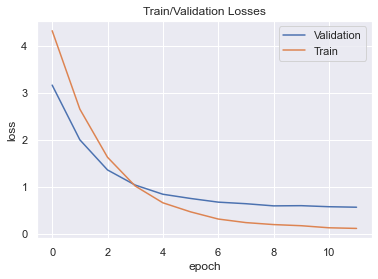

Test Loss: 0.642357


Test Accuracy: 85% (5252/6149)
========== Ending Training ==========
    Train loss: 0.11109174806259427
    Valid loss: 0.5621759068293899
    Test  loss: 0.6423574340173861
    


In [20]:
#################################
# Train using SGD optimizer #
#################################
# Momentum + Nesterov + 1e-3 LR 

train_valid_test(True, 'SGD', epochs, batches, sgd_path2, sgd_json2, 1, lr=0.001)

========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: Adagrad
    Batch size: 10
    Path: models/adagrad.pt
    Epochs: 12
    Learning rate: 0.01
    
Validation loss decreased (inf --> 4.723498).  Saving model ...
Validation loss decreased (4.723498 --> 4.345218).  Saving model ...
Validation loss decreased (4.345218 --> 4.085969).  Saving model ...
Validation loss decreased (4.085969 --> 3.887163).  Saving model ...
Epoch: 5 	Training Loss: 3.959734 	Validation Loss: 3.726014
Validation loss decreased (3.887163 --> 3.726014).  Saving model ...
Validation loss decreased (3.726014 --> 3.546605).  Saving model ...
Validation loss decreased (3.546605 --> 3.422680).  Saving model ...
Validation loss decreased (3.422680 --> 3.287566).  Saving model ...
Epoch: 10 	Training Loss: 3.192213 	Validation Loss: 3.106611
Validation loss decreased (3.287566 --> 3.106611).  Saving model ...
Validation loss decreased (3.106611 --> 2.999794).  Saving model ...
Valida

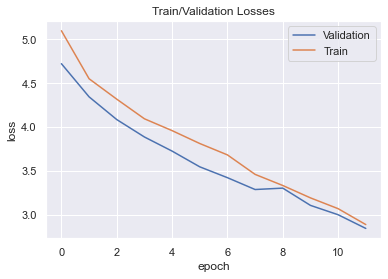

Test Loss: 3.064032


Test Accuracy: 23% (1417/6149)
========== Ending Training ==========
    Train loss: 2.8874646542119047
    Valid loss: 2.843604695563223
    Test  loss: 3.064031970597861
    


In [21]:
#################################
# Train using Adagrad optimizer #
#################################

train_valid_test(True, 'Adagrad', epochs, batches, adagrad_path, adagrad_json, 2, 0.01)

========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: Adam
    Batch size: 10
    Path: models/adam.pt
    Epochs: 12
    Learning rate: 0.0003
    
Validation loss decreased (inf --> 1.883810).  Saving model ...
Validation loss decreased (1.883810 --> 1.314999).  Saving model ...
Validation loss decreased (1.314999 --> 0.905556).  Saving model ...
Validation loss decreased (0.905556 --> 0.628322).  Saving model ...
Epoch: 5 	Training Loss: 0.156417 	Validation Loss: 0.635096
Validation loss decreased (0.628322 --> 0.433484).  Saving model ...
Validation loss decreased (0.433484 --> 0.400649).  Saving model ...
Validation loss decreased (0.400649 --> 0.397444).  Saving model ...
Epoch: 10 	Training Loss: 0.019507 	Validation Loss: 0.413715


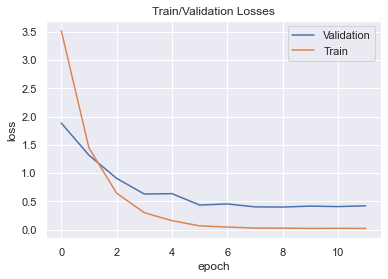

Test Loss: 0.511849


Test Accuracy: 86% (5319/6149)
========== Ending Training ==========
    Train loss: 0.019370175368499522
    Valid loss: 0.41963025677821364
    Test  loss: 0.5118493400824573
    


In [8]:
#################################
# Train using Adam optimizer #
#################################

train_valid_test(True, 'Adam', epochs, batches, adam_path, adam_json, 3, 0.0003)

### Compare results <a class="anchor" id="compare"/>
We see that Adam had the best model which scored 86%, whereas Adagrad (which is my favorite) scored depressing 23%. The most interesting pattern is that all of the algorithms' validation scores were better at the beginning. Also, SGD and Adam have exponential loss decline, whereas Adagrad follows more of a linear one. 

Our next step is to compare the results. Since I love visualizations and strongly believe that they can give better understanding, we will see multi-step approach. It will include the following:
* side-by-side visualizations
* top best and worst models' predictions on a test set's batch of 10 images
* top model's performance on the whole dataset, along with the worst prediction's confusions
* best and worst models' top 5 predictions on unseen data (after additional training at the end)

In [8]:
# load the results 
with open('models/sgd_momentum1.json') as file:
    sgd_results = json.load(file)

with open('models/sgd_momentum2.json') as file:
    sgd_results2 = json.load(file)
    
with open('models/adagrad.json') as file:
    adagrad_results = json.load(file)

with open('models/adam.json') as file:
    adam_results = json.load(file)

# visualize training and validation values over epoch
visualize.side_by_side([sgd_results, sgd_results2, adagrad_results, adam_results], n_plots=4,
                       names=['SGD 0.01LR', 'SGD 0.001LR', 'Adagrad', 'Adam'])

In [10]:
def visualize_final_results(path):
    # visualize a random batch
    model = get_model()
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    visualize.batch(iter(test_loader), label_dict, 10, actual_order, use_cuda, model=model)

def visualize_confusion(results):
    first_half, second_half = visualize.show_test_results(results['test_dict'])
    return [first_half, second_half]
    
def most_confused(results, second_half, top_k):
    # visualize most confused
    confused = visualize.get_confusions(results['confused_with'], label_dict, actual_order)
    last_n = second_half.iloc[-top_k:, 0].to_list()

    for last in last_n:
        visualize.visualize_most_confused(last, confused, label_inverse=label_inverse)

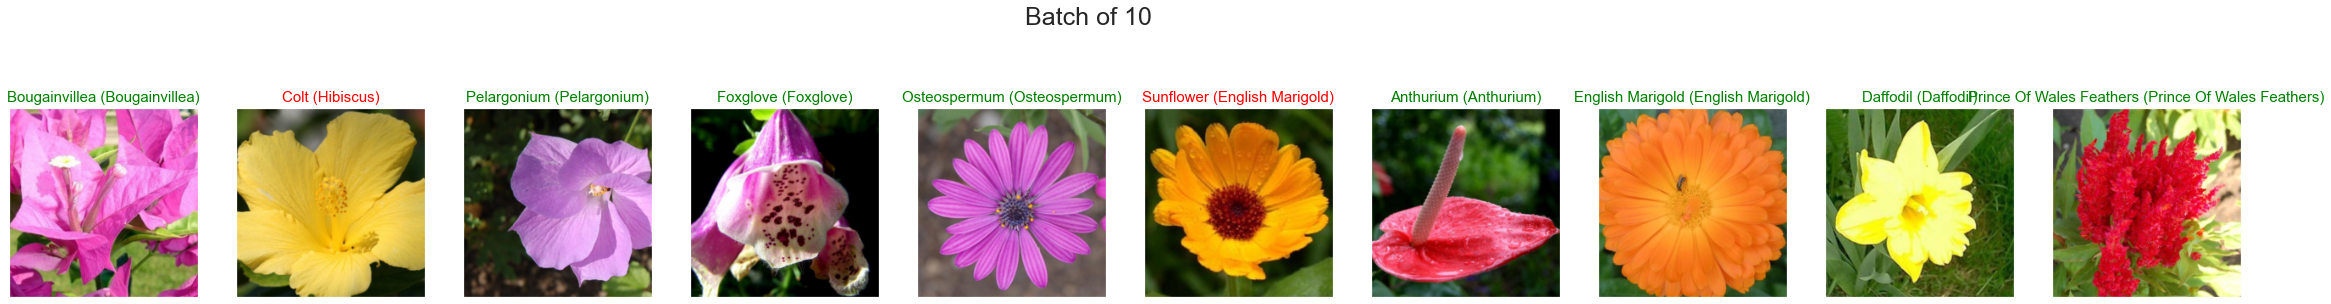

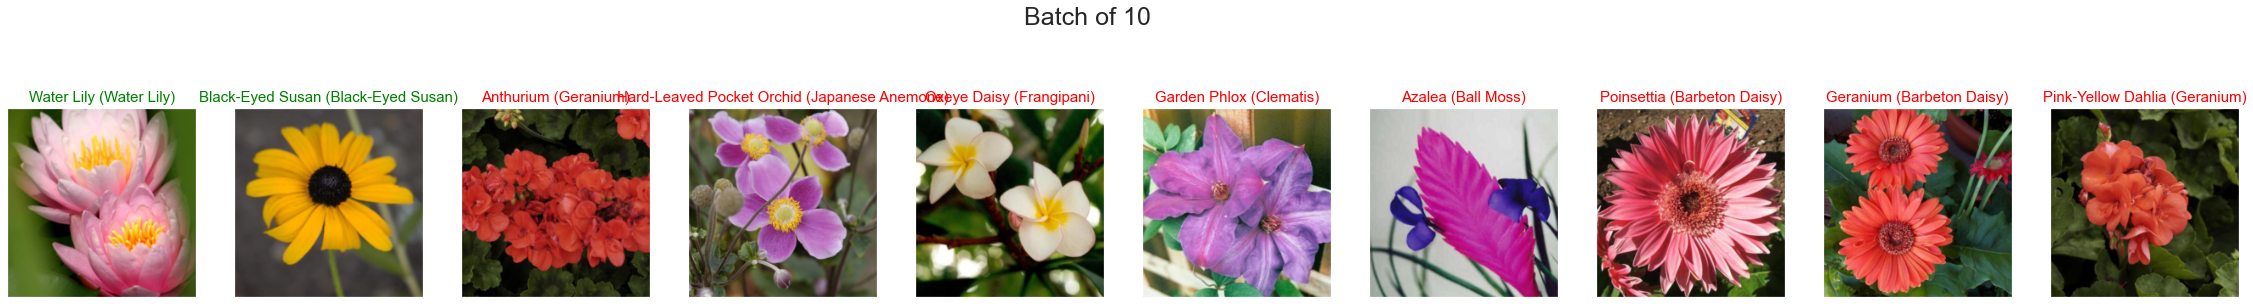

In [11]:
visualize_final_results(adam_path)
visualize_final_results(adagrad_path)

In [12]:
_, second_half = visualize_confusion(adam_results)

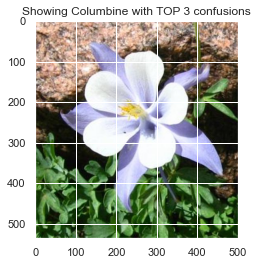

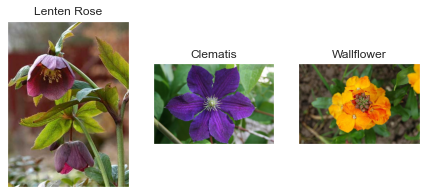

In [13]:
most_confused(adam_results, second_half, 1)

### Additional challenge <a class="anchor" id="challenge"/>
Both Stochastic Gradient Descent (with starting 1e-3 learning rate) and Adam optimizers scored similarly, with difference in 1%. However, Adagrad performed the worst, losing to its opponents by almost 60%. In this following section, I want to introduce additional challenge by using more transformations. 

After spending some days going through state-of-the-art research papers on image preprocessing, the one that caught my attention was "Transformation pursuit for image classification" [3] and "Automated flower classification over a large number of classes" [4]. The first paper proposes a subset of transformations: cropping, homography, scaling, colorimetry, JPEG compression, rotation, and Order-K. The second, however, mentions an amazing technique of "foreground-segmentation". Since the segmentation technique requires advanced knowledge of Computer Vision, I've decided to put off the idea until I get to that level. However, the first one is doable but some modifications need to be applied. The paper mentions "colorimetry" which is changing colometric values by computing the "covariance matrix of RGB components of the whole dataset". After running it on NAG, I saw that the test results were almost identical as in Adagrad example. Then only I understood that some flowers are distinguished by color only. Changing it will only worsen the situation with classifications. So, I've decided to go with the following set of transformations (I will include the ones that are altered or newly introduced):
* Random rotation by 30 degrees both directions
* Random vertical flip with 70% probability
* Random perspective: performs a random perspective transformation with 30% probability
* Random posterization: reduces the bits of color channels 


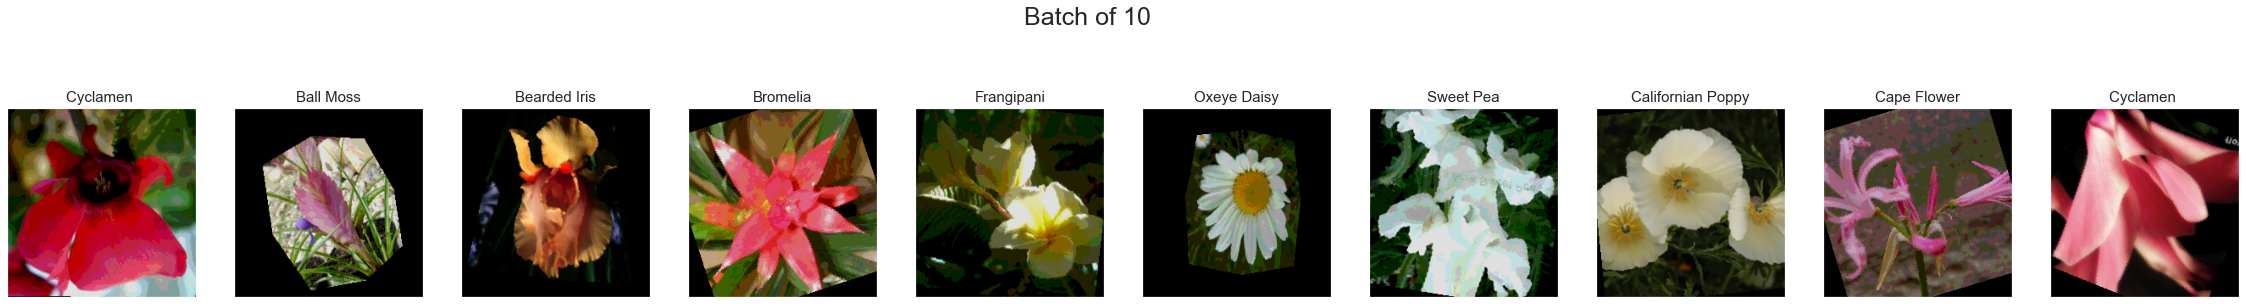

In [27]:
transformations = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomRotation(30),
        transforms.RandomVerticalFlip(p=0.7),
        transforms.RandomPerspective(p=0.3),
        transforms.RandomPosterize(bits=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test_valid': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

model = get_model()
path = f'models/sgd_more_transforms2_{batch}batches.pt'
# visualize the new transformations
train_loader, _, _ = helper.create_loaders(10, transformations)
visualize.batch(iter(train_loader), label_dict, 10, actual_order)

========== Starting Training ==========
    Loss function: CrossEntropy
    Optimizer: SGD
    Batch size: 10
    Path: models/sgd_more_transforms2_10batches.pt
    Epochs: 12
    Learning rate: 0.001
    
Validation loss decreased (inf --> 3.558448).  Saving model ...
Validation loss decreased (3.558448 --> 2.396276).  Saving model ...
Validation loss decreased (2.396276 --> 1.682341).  Saving model ...
Validation loss decreased (1.682341 --> 1.300503).  Saving model ...
Epoch: 5 	Training Loss: 1.274184 	Validation Loss: 1.087169
Validation loss decreased (1.300503 --> 1.087169).  Saving model ...
Validation loss decreased (1.087169 --> 0.925949).  Saving model ...
Validation loss decreased (0.925949 --> 0.809216).  Saving model ...
Validation loss decreased (0.809216 --> 0.753427).  Saving model ...
Validation loss decreased (0.753427 --> 0.679491).  Saving model ...
Epoch: 10 	Training Loss: 0.447346 	Validation Loss: 0.621613
Validation loss decreased (0.679491 --> 0.621613).  Sav

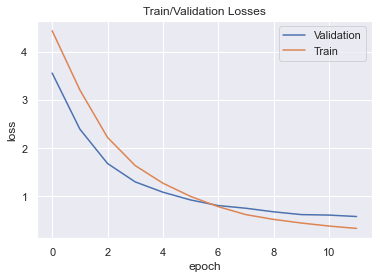

Test Loss: 0.709235


Test Accuracy: 83% (5113/6149)
========== Ending Training ==========
    Train loss: 0.33481420824925107
    Valid loss: 0.5817849644478045
    Test  loss: 0.709234743262452
    


In [28]:
train_loss, valid_loss, test_loss, model, confused_with, test_dict = train_test.set_params(
        12, model, label_dict, actual_order, use_cuda, save_path=path, learning_decay=True, 
        optim_name='SGD', n_batch=batch, transformations=transformations, lr=0.001)

results.append({'train_loss': train_loss, 'valid_loss': valid_loss, 'test_loss': test_loss,
                   'confused_with': confused_with, 'test_dict': test_dict, 'path': path,
                    'optim': 'SGD', 'batch_size': batch})

with open('models/sgd3_results.json', 'w') as file:
    json.dump(results[3], file)

### Conclusion
Today we looked at the classification task where we needed to predict flowers from 102 categories. 

### Reference
[1] Sutskever, Ilya, et al. "On the importance of initialization and momentum in deep learning." International conference on machine learning. PMLR, 2013. <br>
[2] Lydia, Agnes, and Sagayaraj Francis. "Adagrad—an optimizer for stochastic gradient descent." Int. J. Inf. Comput. Sci 6.5 (2019). <br>
[3] Paulin, Mattis, et al. "Transformation pursuit for image classification." Proceedings of the IEEE conference on computer vision and pattern recognition. 2014. <br>
[4] Nilsback, Maria-Elena, and Andrew Zisserman. "Automated flower classification over a large number of classes." 2008 Sixth Indian Conference on Computer Vision, Graphics & Image Processing. IEEE, 2008.